In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
import sys
import os
sys.path.append('../')

from models.SSA import SSA
plt.style.use('seaborn-v0_8-whitegrid')

PATH = os.path.join(os.path.dirname(os.getcwd()), r'data')

# Содержание
* [1. Суть исследования](#1.\-Суть-исследования)
* [2. Подготовка данных](#2.\-Подготовка-данных)
* [3. Определение инструментария (методология)](#3.\-Определение-инструментария-(методология))
* [4. Эксперименты с компонентами](#4.\-Эксперименты-с-компонентами)
* [5. Эксперименты с аппроксимацией](#5.\-Эксперименты-с-аппроксимацией)
* [6. Дробление ряда](#6.\-Дробление-ряда)
* [7. Результаты](#7.\-Результаты)

# 1. Суть исследования



Посмотрим на то, как именно "дополнительная информация" о ряде влияет на компоненты. Рассмотрим 2 сценария:
1. Фиксируем threshold, берём лишь часть временного ряда до threshold, а затем раскладываем эту часть с помощью SSA.
2. Фиксируем threshold, *раскладываем весь ряд*, а затем оставляем только данные до threshold.

Как видно, во втором сценарии у нас есть "информацию о будущем", которая теоретически должна помочь лучше аппроксимировать ряд. 

Далее под **компонентой** будем подразумевать номер получившегося ряда в SVD разложении (начиная с 1). Посмотрим на первую компоненту для [ряда, определенного ниже](https://www.kaggle.com/datasets/jessemostipak/beer-production/data): здесь желтая линия - реализация первого сценария, а синия - второго. 

![](Gif.gif)

Ясно видно, что сильные изменения (ошибка аппроксимации) первой компоненты есть лишь в начале, и в конце. Сохраняется ли такой эффект для каждой из компонент любого ряда? Как ведет себя ошибка аппроксимации для малорангового приближения всего ряда, а не только его компонент?

**Гипотезы**
1. Информация о будущих наблюдениях сильнее всего влияет на первые и последние позиции компоненты.
2. Количество позиций с высокой ошибкой аппроксимации пропорционально длине окна.
3. SSA хуже всего приближает первые и последние наблюдения ряда.

NB! В работе рассматривались ряды без выбросов, чтобы компоненты, выделяемые SVD были интерпретируемы и обладали обобщающей способностью.    

<div style="border: 2px solid #4CAF50; background-color: #ffffff; padding: 10px; border-radius: 5px;">

**Почему важно это изучить?**

- Если окажется, что гипотеза верна, то в прогнозировании ряда и разложении его на компоненты стоит учитывать, что SSA ошибается чаще на первых и последних наблюдениях.
- Понять, как ведет себя алгоритм при наличии информации "из будущего"
</div>


# 2. Подготовка данных

Далее будут использованы три ряда:

**Реальные данные про производству пива**, [kaggle.com](https://www.kaggle.com/datasets/jessemostipak/beer-production/data)

**Экспоненциально косинусный ряд**:
$$
f_n = Ae^{\alpha n}\cos{(2\pi \omega n + \phi)}
$$
 

$$A \neq 0, \alpha \in (0,1), \omega \in [0,1/2], \phi \in [0,2\pi)$$

При $\omega \neq 0$ ряд имеет ранг 2, т.е. каждое наблюдение $f_n$ - линейная комбинация двух векторов $y_1 =  e^{\alpha (n-1)}\cos{(2\pi \omega (n-1))}, y_2 = e^{\alpha (n-1)}\sin{(2\pi \omega (n-1))}$

При этом ранг ряда определяется как ранг траекторной матрицы ($d$), если $d <\min(L,K)$ 

В этом легко можно убедиться расписав их линейную комбинацию как косинус разности
$$
f_n = e^{\alpha(n-1)}(a\cos{(2\pi \omega (n-1))} + b\sin{(2\pi \omega (n-1))}), a,b \in \mathbb{R} 
$$
$$
f_n =  e^{\alpha(n-1)}\sqrt{a^2+b^2}[\frac{a}{\sqrt{a^2+b^2}}\cos{(2\pi \omega (n-1))} + \frac{b}{\sqrt{a^2+b^2}}\sin{(2\pi \omega (n-1))}]
$$
$$
f_n = e^{\alpha(n-1) + \ln\sqrt{a^2+b^2}}\cos{(2\pi\omega n - 2\pi\omega-\gamma})
$$

Далее остается подобрать такие $a,b$, чтобы итоговое выражение удовлетворяло $f_n(n)$

Для эксперимента брались значения $A = 2, \omega = 0.025, \alpha = -0.005, \phi = \pi / 3$, соответствующие затухающему волнообразному сигналу.

**Экспоненциально косинусный ряд с шумом**

Чтобы искусственно увеличить число значимых компонент ряд зашумлялся с помощью стохастического шума (белого с $\sigma = 0.5$). 

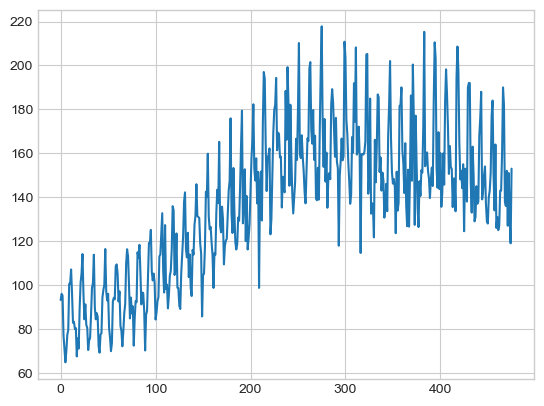

In [12]:
# данные из https://www.kaggle.com/datasets/jessemostipak/beer-production/data
ts = pd.read_csv(os.path.join(PATH, 'beer_production.csv'))['Monthly beer production'].to_numpy()
plt.plot(ts);

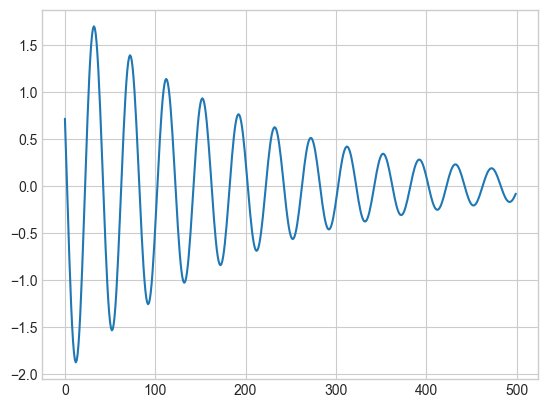

In [3]:
x = np.linspace(1,500, 500)

def exp_cosine(x, A, w, alpha, phi):
    return A*np.exp(alpha*x)*np.cos(2*np.pi*w*x + phi)

exp_cosine_np = np.vectorize(exp_cosine, excluded = ['A', 'w','alpha','phi'])
ts_expcosine = exp_cosine_np(x, A = 2, w = 0.025, alpha = -0.005, phi = np.pi / 3)
plt.plot(ts_expcosine);

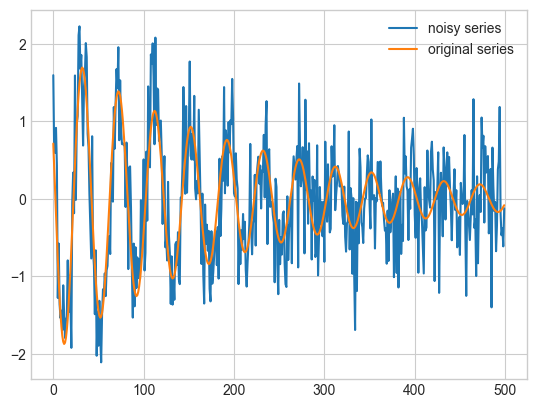

In [4]:
# пошумим
np.random.seed(0)
ts_expcosine_noisy = ts_expcosine + np.random.normal(size = ts_expcosine.shape, scale = 0.5, )
plt.plot(ts_expcosine_noisy, label = 'noisy series')
plt.plot(ts_expcosine, label = 'original series')
plt.legend();

# 3. Определение инструментария (методология)



В этом разделе будут заданы функции, использованные в дальнейшем.

*Ключевой блок в функциях - перебор всех значений `threshold`* для данного `l`. Допустимые значения были выбраны как `range(l+10, ts.shape)`, чтобы маленькие порогие получали значимую информацию о ряде, помимо одного вектора длины `l`. 

При каждом `threshold` можем найти вектор абсолютных ошибок между реализацией сценария один (сначала отрезаем, потом раскладываем) и сценария два (сначала раскладываем, потом отрезаем). Длина такого вектора, очевидно равна порогу. 

Чтобы обобщить результаты для всех `threshold`, нужно посчитать агрегированные статистики. В первую очередь, выделим индексы тех позиций, на которых ошибка аппроксимации сильно отличается - для этого использовалось 1.5 интерквартильных размаха. Во-вторых, векторы ошибок имеют разную длину, поэтому для соответствия индексов перенумеруем индексы второй половины наблюдений как отрицательные в стиле стандартной индексации python. К примеру, если для вектора длины $n = 20$ получили индексы $[0,1,18,19]$, преобразуем их к $[0,1,-2,-1]$. Далее, для всех `threshold` посчитаем частоту встречаемости выделенных индексов. *Частота покажет, на каких позициях алгоритм ошибается чаще всего*.   

**О функциях**

`get_index(...)` - достаёт индексы элементов, которые больше третьего квартиля + 1.5 интерквартильных размаха

`analyse_component(...)` - применяет всю процедуру, описанную выше

`plot_frequencies(...)` - отображает столбчатую диаграмму индексов и их частоты. 

`analyse_l(...)` - аналогична `analyse_component`, но работает быстрее, если нужно проанализировать несколько компонент. 

`analyse_approximation(...)` - возвращает вектор абсолютных ошибок для малоранговой аппроксимации полного исходного ряда.

In [6]:
from collections import defaultdict

def get_index(array):
    '''
    array: numpy.1darray

    returns: indexes of outliers
    an outlier - is an observation which deviates
    from 3d quartile on more than 1.5 interquartile range
    '''
    q1 = np.quantile(array,0.25)
    q3 = np.quantile(array,0.75)
    indexes = np.where(array > q3 + 1.5*(q3 - q1))[0]
    n = array.shape[0]
    
    # if index is in the second half of observations,
    # it goes as negative index
    indexes[indexes > (n-1) // 2] -= n

    return indexes

# function for analysing indexes of outliers
def analyse_component(ts, l = 10, n_component = 2):
    '''
    ts: np.1darray
    l: int, window length
    n_component: int

    returns
    results: dict {vector_threshold: np.array, norm_threshold: np.array}
    norms: list 
    index_frequency: dict {index : int}
    mean_len: float
    '''

    results = {}

    # for each threshold perform 2 scenarios (see section 1)
    for threshold in range(l+20,ts.shape[0]):
        ts_1 = ts[:threshold] # first scenario
        ts_2 = ts # second scenario

        ssa = SSA(l = l)
        ssa_ts_1 = ssa.transform_to_series(ts_1)[n_component-1, :]
        ssa_ts_2 = ssa.transform_to_series(ts_2)[n_component-1, :threshold]
        
        # vector_threshold - vector of absolute errors between 2 scenarios
        # vector_threshold = |first_scenario_i - second_scenario_i| for particular threshold
        results[f'vector_{threshold}'] = np.abs(ssa_ts_1 - ssa_ts_2)

        # euclidean norm of error vector 
        results[f'norm_{threshold}'] = np.linalg.norm(ssa_ts_1 - ssa_ts_2)
        
    # for each error vector calculate indexes of outliers
    # calculate frequency of a particular index for all error vectors
    index_frequency = defaultdict(lambda:0)
    mean_len = 0
    for threshold in range(l+20,ts.shape[0]):
        indexes = get_index(results[f'vector_{threshold}'])
        for index in indexes:
            index_frequency[index] += 1
        # mean len is an average number of outlier for all thresholds 
        mean_len += len(indexes) / (ts.shape[0] - l - 20) 

    norms = [results[f'norm_{threshold}'] for threshold in range(l+20,ts.shape[0])]

    return results, norms, index_frequency, mean_len

def plot_frequencies(index_frequency, l, n_component, ax = None):
    '''
    index_frequency: dict {index: int (frequency)}
    l: int, window lenght
    n_component: int
    ax: matplotlib.axes.Axes

    inline plotting barchart of frequencies

    '''
    # sorting by index
    index_frequency_map = sorted(index_frequency.items(), key = lambda x: x[0], reverse = True)
    y_ticks = np.array(list(map(lambda x: str(x[0]), index_frequency_map)))
    x_ticks = np.array(list(map(lambda x: x[1], index_frequency_map)))

    # on y axis only lowest, highest and mode values will be signed
    y_locator = [0, 
                np.argmax(x_ticks),  
                y_ticks.shape[0] - 1]
    if ax is not None:
        sns.barplot(x = x_ticks, 
                    y = y_ticks, 
                    orient = 'h', ax = ax)
        
        ax.set_yticks(y_locator, y_ticks[y_locator])
        
        ax.set_ylabel('ranged indexes')
        ax.set_xlabel('frequency')
        ax.set_title(f'$l = {l}$, $n\_component = {n_component}$');
    else:
        sns.barplot(x = x_ticks, 
                    y = y_ticks, 
                    orient = 'h', ax = ax)
        
        plt.yticks(y_locator, y_ticks[y_locator])
        
        plt.ylabel('ranged indexes')
        plt.xlabel('frequency')
        plt.title(f'$l = {l}$, $n\_component = {n_component}$');

# function for analysing mean number of outliers for a list of components
# the only difference with analyse_component is 
# more effective usage of loop (without perfoming SSA for each component)
def analyse_l(ts, n_components, l = 10):
    '''
    ts: np.1darray
    n_components: itterable object with ints
    l: int, window lenght

    returns list of mean number of outliers for each component
    '''

    results = defaultdict(lambda: {})

    for threshold in range(l+20,ts.shape[0]):
      ts_1 = ts[:threshold]
      ts_2 = ts

      ssa = SSA(l = l)
      ssa_ts_1 = ssa.transform_to_series(ts_1)
      ssa_ts_2 = ssa.transform_to_series(ts_2)
      for n_component in n_components:
      
        ssa_ts_1_n = ssa_ts_1[n_component - 1, :]
        ssa_ts_2_n = ssa_ts_2[n_component - 1, :]
        results[n_component][f'vector_{threshold}'] = np.abs(ssa_ts_1_n - ssa_ts_2_n[:threshold])
        
    index_frequency = defaultdict(lambda:0)
    mean_lenghts = []
    for n_component in n_components:
      mean_len = 0
      for threshold in range(l+20,ts.shape[0]):
          indexes = get_index(results[n_component][f'vector_{threshold}'])
          for index in indexes:
              index_frequency[index] += 1
          mean_len += len(indexes) / (ts.shape[0] - l - 20)
      mean_lenghts.append(mean_len)


    return mean_lenghts

# function for analysing error of low-rank approximation of full series
def analyse_approximation(ts, l, rank):
    '''
    ts: np.1darray
    l: int, window length
    rank: int, how many components to use

    returns 
    absolute_error: np.1darray, vector of absolute error
    '''
    ssa = SSA(l = l)
    ts_approx = ssa.transform_to_series(ts)[:rank-1, :].sum(axis = 0)
    
    absolute_error = np.abs(ts - ts_approx)
    
    return absolute_error

# 4. Эксперименты с компонентами

## С реальными данными

Из графика абсолютной ошибки для первой компоненты видно, что ошибка действительно максимальна в начале и в конце вектора для любого `threshold`. Однако, если проделать то же самое для компоненты $>3$, то график будет куда более шумным: *в середине ряда есть пики ошибок*. Значит, первую гипотезу нужно скорректировать: *возможно, для компонент с самыми значительными сингулярными числами ошибка максимальна на концах вектора*.     

Mean number of higly deviant observations: 17.06726457399095


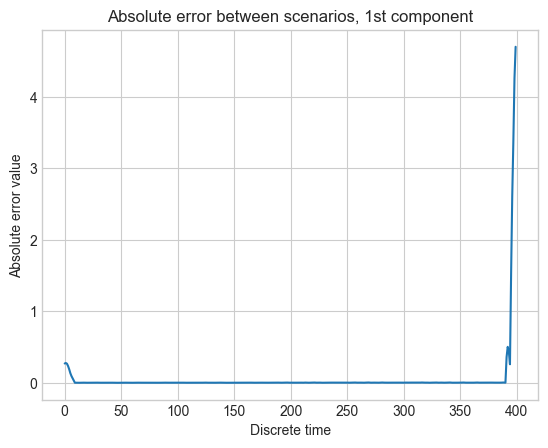

In [7]:
results, norms, index_frequency, mean_len = analyse_component(ts, l = 10, n_component = 1)

print(f'Mean number of higly deviant observations: {mean_len}')
plt.plot(results['vector_400']) # здесь можно поменять на вектор vector_i, чтобы визуализировать для разных threshold
plt.title('Absolute error between scenarios, 1st component')
plt.xlabel('Discrete time')
plt.ylabel('Absolute error value');

Mean number of higly deviant observations: 10.204035874439462


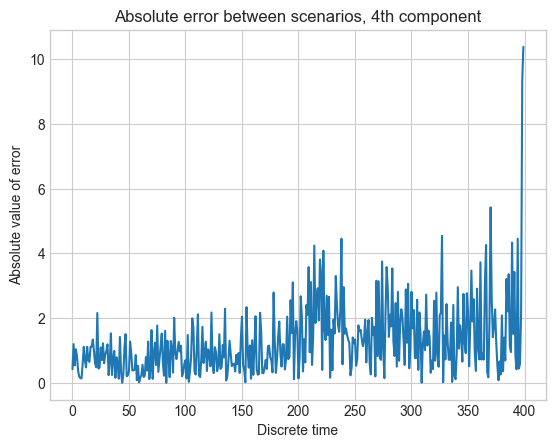

In [8]:
results, norms, index_frequency, mean_len = analyse_component(ts, l = 10, n_component = 4)

print(f'Mean number of higly deviant observations: {mean_len}')
plt.plot(results['vector_400'])
plt.title('Absolute error between scenarios, 4th component')
plt.xlabel('Discrete time')
plt.ylabel('Absolute value of error');

Норма ошибок между сценариями меньше и более осциллируема для первой компоненты, чем для четвертой. Это можно объяснить колебательным характером данных: первая компонента "переобучается" в конце доступных данных, не учитывая возможные снижения значений ряда, которые улавливает второй сценарий, построенный на всём ряду.

Норма четвертой компоненты имеет яркие пики, которые, скорее всего, возникают из-за случайных особенностей данных.

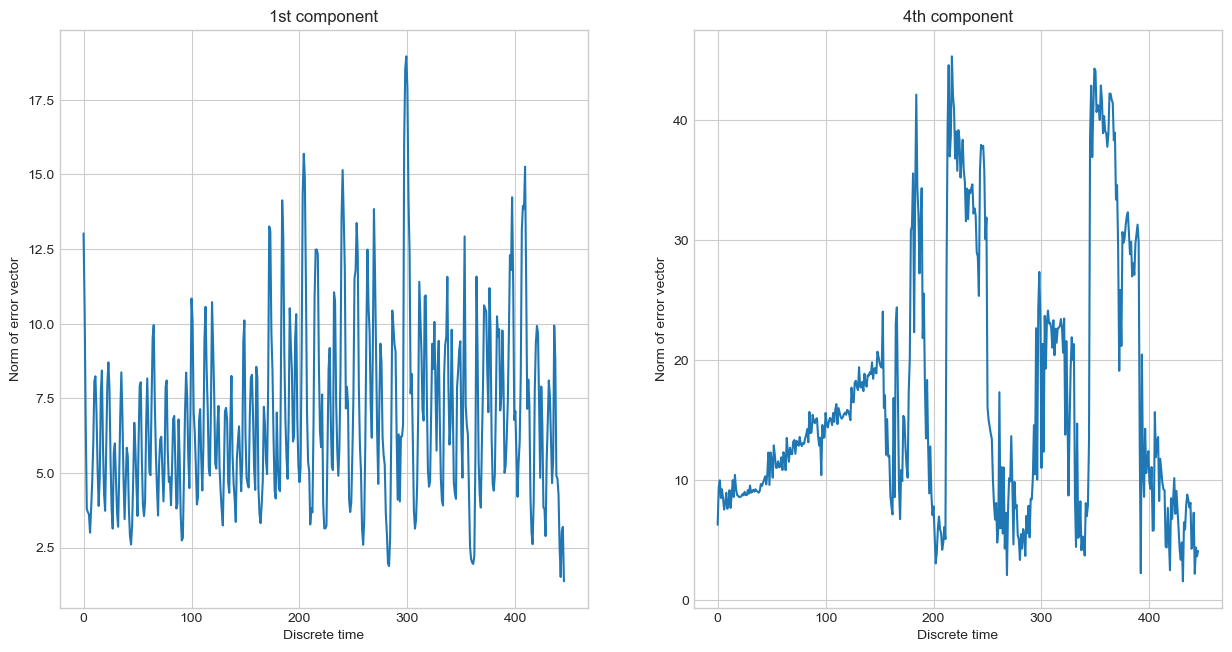

In [44]:
_, norms_1, _, _ = analyse_component(ts, l = 10, n_component = 1)
_, norms_4, _, _ = analyse_component(ts, l = 10, n_component = 4)

fig, ax = plt.subplots(1,2, figsize=(15,7.5))

ax[0].plot(norms_1)
ax[0].set_xlabel('Discrete time')
ax[0].set_ylabel('Norm of error vector')
ax[0].set_title('1st component')

ax[1].plot(norms_4)
ax[1].set_xlabel('Discrete time')
ax[1].set_ylabel('Norm of error vector')
ax[1].set_title('4th component');

**Устройство графиков с частотой**. По вертикальной оси отложены индексы в порядке возрастания, во избежание визуального мусора на оси отмечены только 3 основных значения: максимальное, минимальное и мода (индекс с максимальной частотой по горизонтальной оси). Индексы вблизи нуля - это первые ($>0$) и последние ($<0$) значения ряда ошибок, чем выше индекс, тем он ближе к центру. О том, как считается частота см. часть 3. 


<a href="https://ibb.co/qYjMwBs"><img src="https://i.ibb.co/m5TC7Jq/03-01-2024-07-59-01.png" alt="03-01-2024-07-59-01" border="0"></a>


**Зависимость от компоненты**. Для всех компонент размах индексов высок - иначе говоря, *существуют `thresholds`, для которых в середине ряда ошибка аппроксимации высока*. При этом, количество индексов с высокой частотой ниже у первых компонент. Последние компоненты ошибаются между двумя сценариями и не на концах ряда. Итого, первая гипотеза оправдалась лишь отчасти: между компонентной и индексами ошибок очевидно существует взаимосвязь, но и первые компоненты ошибаются в середине ряда.

**Зависимость от длины окна.** Чем выше $l$, тем больше размах индексов с частыми ошибками для первой компоненты. Более того, при $l\geq20$ полностью подтверждается первая гипотеза - значит, индексы ошибок между сценариями существенно зависят от подобранного окна. $l=60$ - интересное наблюдение, в котором ошибки происходят на концах векторов чаще, чем в начале, а среднее количество таких ошибок (см. соответствующий график) ниже по сравнению с $l=50$, несмотря на увеличившийся размах.  

Можно было бы подумать, что увеличение размаха индексов ошибок связано с уменьшившейся нормой ошибок (т.е. ошибаться стали чаще, но на меньшую величину). График средней нормы опровергает это утверждение: средняя норма ошибок почти линейно растет с увеличением $l$. Это связано с тем, что при увеличении $l$ гладкость первой компоненты тоже растет, а поскольку наши данные сильно колебающиеся, то ошибка становится заметнее. Иначе говоря, *"информация о будущем" позволяет сильнее сглаживать тренд*. Это хорошо видно на графике для $l=60, n\_component = 1$:

![](Gif4.gif)

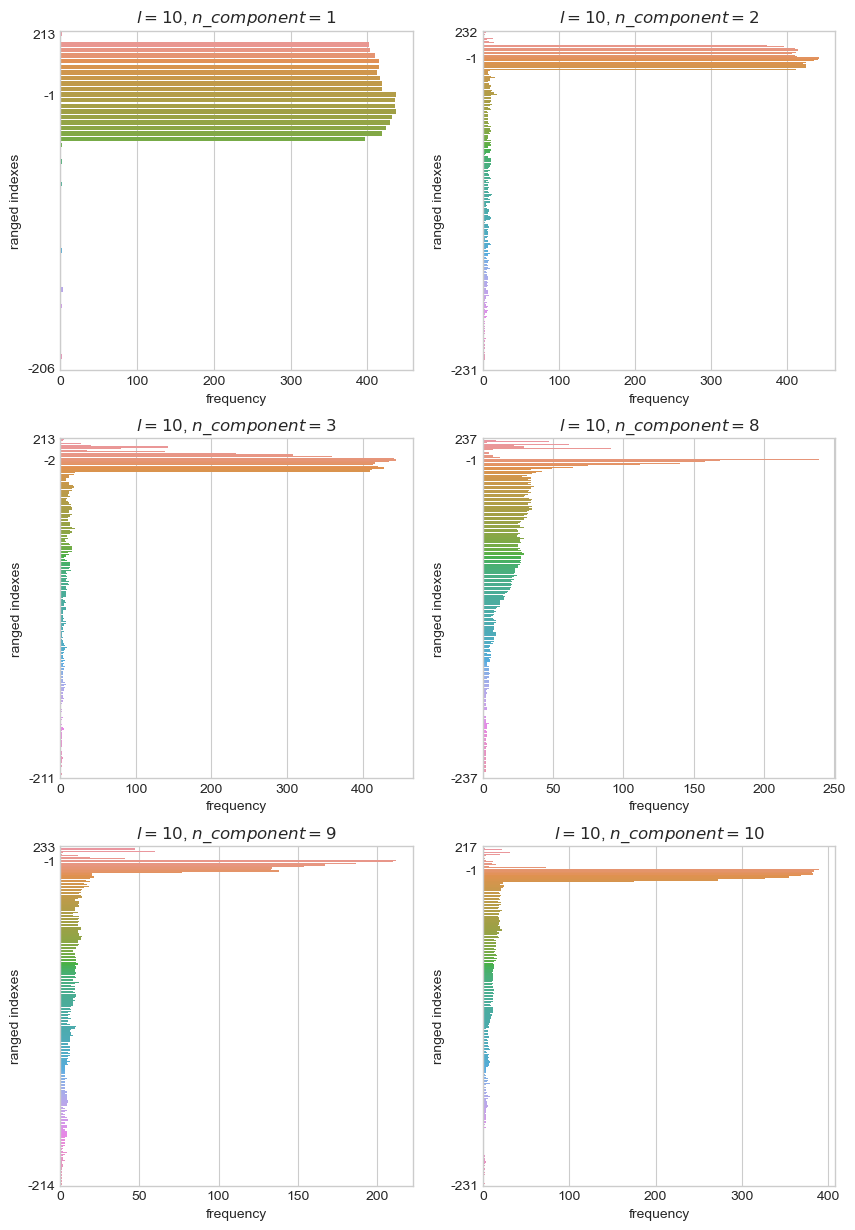

In [36]:
# разные компоненты
fig, ax = plt.subplots(3,2, figsize = (10,15))

for i, n_component in enumerate([1,2,3,8,9,10]):


    _, _, index_frequency, _ = analyse_component(ts, l= 10, n_component=n_component)

    plot_frequencies(index_frequency, l = 10, n_component=n_component, ax = ax[i//2][i%2])

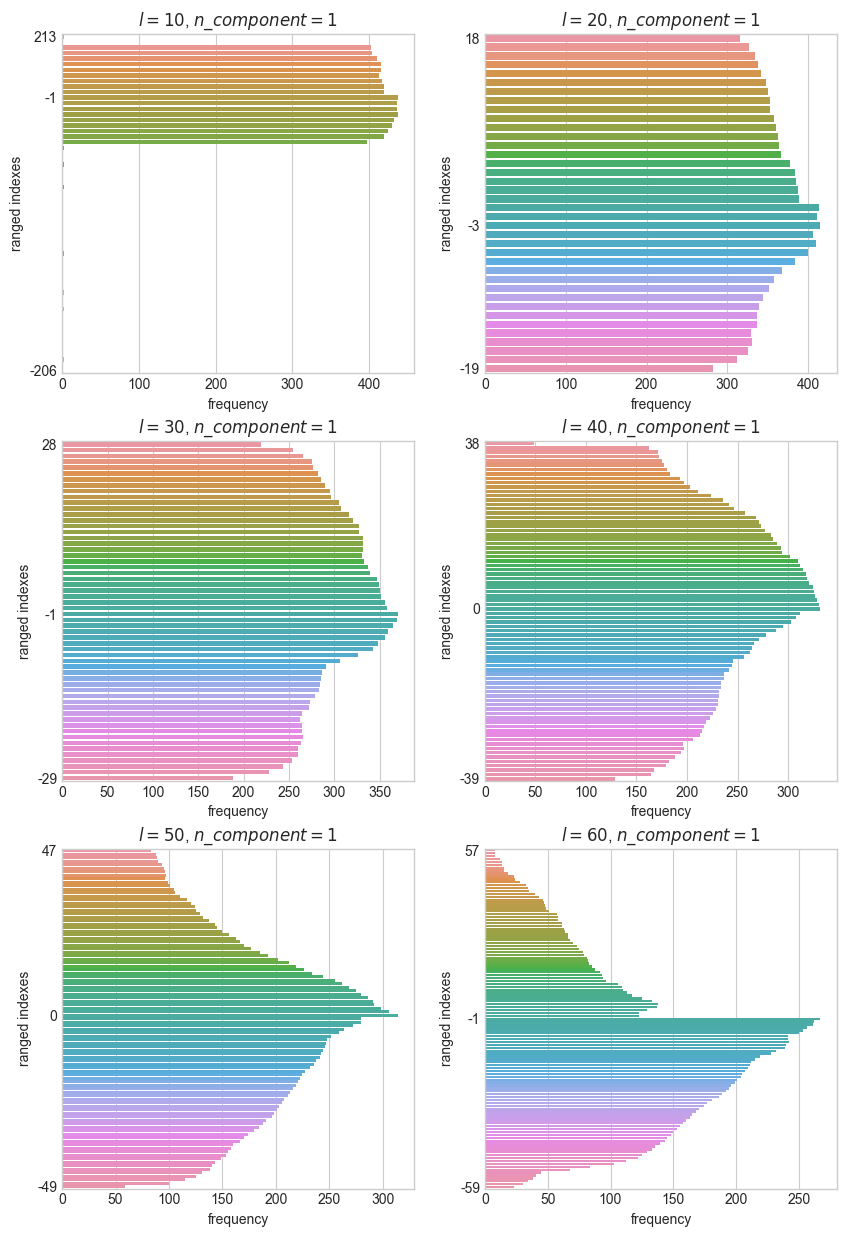

In [9]:
# разные длины окон
fig, ax = plt.subplots(3,2, figsize = (10,15))
n_component = 1
l_list = [10,20,30,40,50,60]
mean_len_list = []

for i, l in enumerate(l_list):


    _, _, index_frequency, mean_len = analyse_component(ts, l= l, n_component=n_component)
    mean_len_list.append(mean_len)
    plot_frequencies(index_frequency, l = l, n_component=n_component, ax = ax[i//2][i%2])

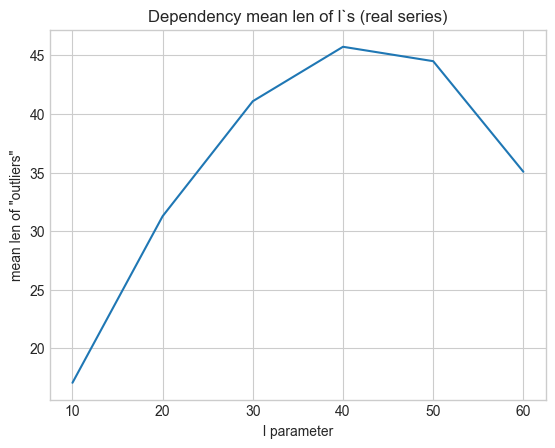

In [10]:
plt.plot(l_list, mean_len_list)
plt.xlabel('l parameter')
plt.ylabel('''mean len of "outliers"''')
plt.title('Dependency mean len of l`s (real series)');
plt.savefig('Fig.6 Dependency mean len of l`s (real series).png', dpi = 300)

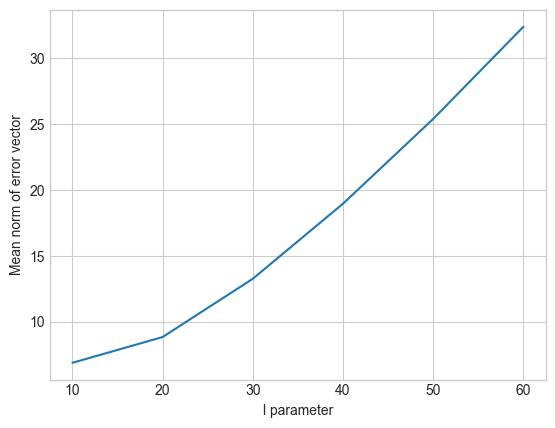

In [27]:
n_component = 1
l_list = [10,20,30,40,50,60]
norms_list = []

for i, l in enumerate(l_list):

    _, norms, _, _ = analyse_component(ts, l= l, n_component=n_component)
    norms_list.append(np.array(norms).mean())

plt.plot(l_list, norms_list)
plt.xlabel('l parameter')
plt.ylabel('Mean norm of error vector')
plt.savefig('Fig.7 Dependency norm of approximation of l`s (real series).png', dpi = 300)

Чтобы полноценно исследовать разные компоненты и длину окна, проведём исследование по сетке
$$
l \in [10,20,\dots, 190]
$$
$$
n\_component \in [1,2, \dots, 10]
$$
На выходе получим матрицу $A \in \mathbb{R}^{19\times 10}$. $a_{ij}$ - среднее количество индексов ошибок (насколько часто ошибается алгоритм) при $l=i, n\_component = j$ 

На графике видно, что 1-3, 4-8, 9-10 компоненты ведут себя схожим образом при изменении окна. *Хотя гипотеза о пропорциональности среднего количества ошибок длине окна не оправдалась, выяснилось, что группы компоненты ведут себя схожим образом, получая информацию "из будущего".*  

In [ ]:
# полное исследование для реальных данных 
# caution: времязатратная ячейка, можно загрузить результаты из beer_research.npy
from tqdm import tqdm
l_list = np.arange(10,200,10)
n_components = np.arange(1,11)
mean_len_matrix = np.zeros((l_list.shape[0], n_components.shape[0]))

for i, l in enumerate(tqdm(l_list)):
        mean_lengths = analyse_l(ts, l = l, n_components=n_components)
        mean_len_matrix[i, :] += mean_lengths

np.save('beer_research', mean_len_matrix)

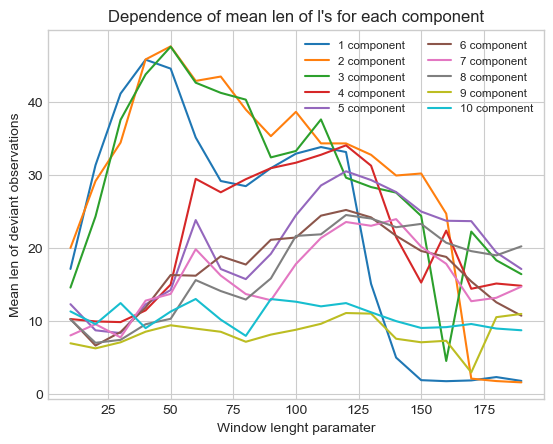

In [26]:
beer_matrix = np.load('beer_research.npy')
for i in range(10):
  plt.plot(np.arange(10,200,10), beer_matrix[:,i], label = f'{i+1} component')

plt.xlabel('Window lenght paramater')
plt.ylabel('Mean len of deviant observations')
plt.title("Dependence of mean len of l's for each component")
plt.legend(ncols = 2, fontsize = 'small');

## Синтетические данные (экспоненциально-косинусный ряд)


Как говорилось ранее, экспоненциально-косинусный ряд вида $f_n = Ae^{\alpha n}\cos{(2\pi \omega n + \phi)}$ имеет ранг 2, а потому исследовать его необходимо только в рамках первых двух компонент.

В случае простого (незашумленного) ряда компоненты ведут себя одинаково в смысле ошибок между сценариями (см. график частот). Изменение длины окна показывает, что *ошибки наиболее часты в конце ряда*. При этом, на некоторых графиках есть явные пики, т.е. без наличия будущих наблюдений алгоритм систематически ошибается на некоторых индексах. 

Mean number of higly deviant observations: 19.434042553191524


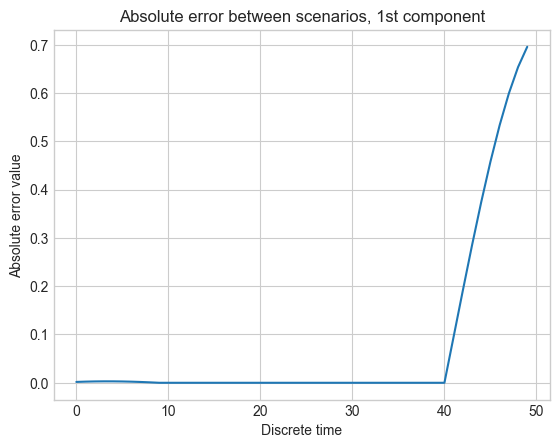

In [35]:
results, norms, index_frequency, mean_len = analyse_component(ts_expcosine, l = 10, n_component = 1)

print(f'Mean number of higly deviant observations: {mean_len}')
plt.plot(results['vector_50']) # здесь можно поменять на вектор vector_i, чтобы визуализировать для разных threshold 
plt.title('Absolute error between scenarios, 1st component')
plt.xlabel('Discrete time')
plt.ylabel('Absolute error value');

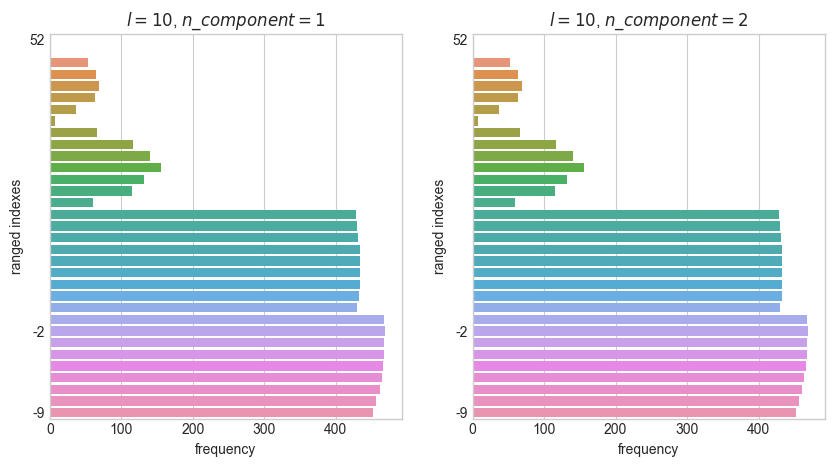

In [30]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, n_component in enumerate([1,2]):


    _, _, index_frequency, _ = analyse_component(ts_expcosine, l= 10, n_component=n_component)

    plot_frequencies(index_frequency, l = 10, n_component=n_component, ax = ax[i%2])

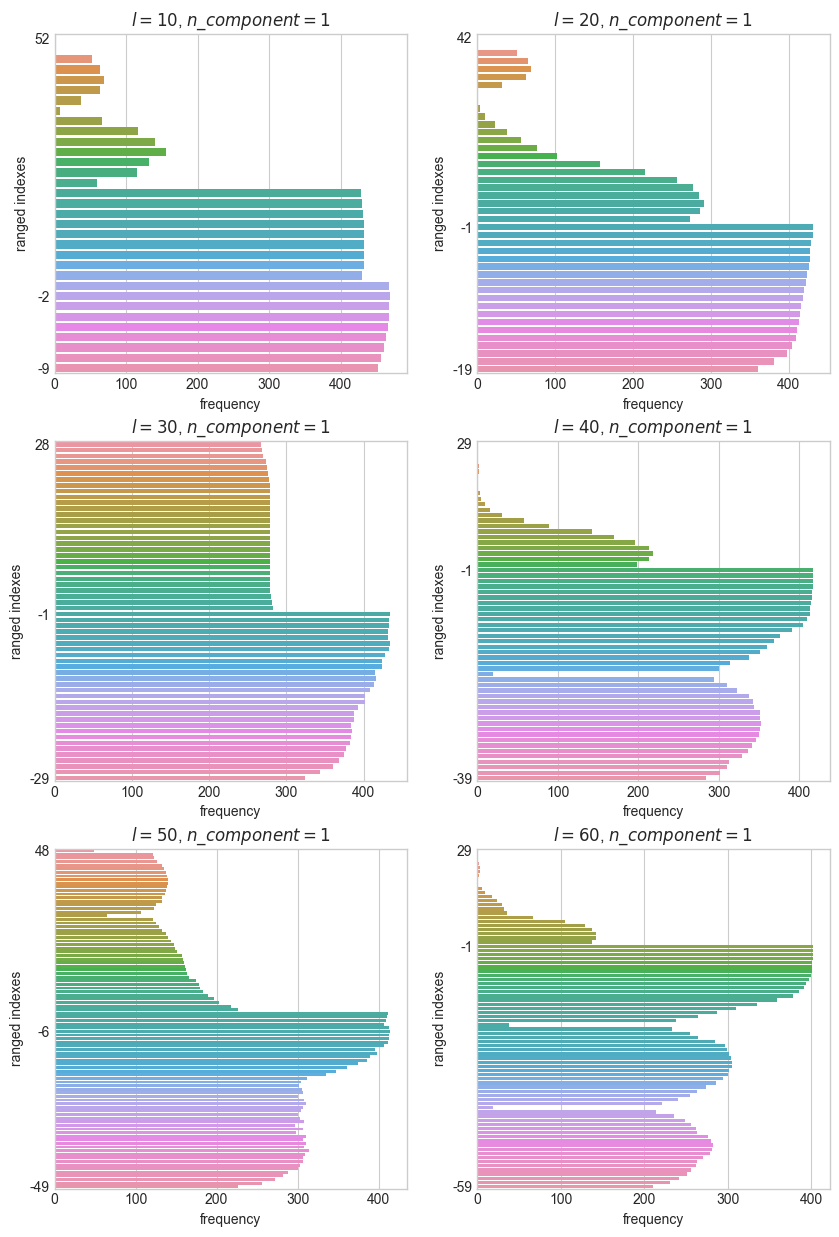

In [31]:
fig, ax = plt.subplots(3,2, figsize = (10,15))
n_component = 1
l_list = [10,20,30,40,50,60]
mean_len_list = []

for i, l in enumerate([10,20,30,40,50,60]):


    _, _, index_frequency, mean_len = analyse_component(ts_expcosine, l = l, n_component=n_component)
    mean_len_list.append(mean_len)
    plot_frequencies(index_frequency, l = l, n_component=n_component, ax = ax[i//2][i%2])

По небольшому набору значений $l$ видно, что вторая гипотеза не оправдывается и для экспоненциально-косинусного ряда: количество индексов ошибок не пропорционально (и даже не монотонно) длине окна. 

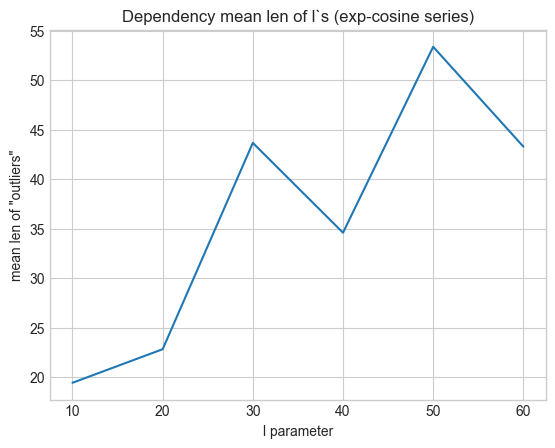

In [32]:
plt.plot(l_list, mean_len_list)
plt.xlabel('l parameter')
plt.ylabel('''mean number of "outliers"''')
plt.title('Dependency mean len of l`s (exp-cosine series)');
plt.savefig('Fig.5 Dependency mean len of l`s (exp-cosine series).png', dpi = 300)

## Синтетические данные (зашумленный экспоненциально-косинусный)

Графики ошибки и частот демонстрируют интересное сходство с незашумленным рядом, что раскрывает понятие "отделимости" гауссовского шума от детерминированных компонент ряда (см. *Analysis of Time Series Structure, Nina Golyandina et al.*) 

Mean number of higly deviant observations: 15.076595744680759


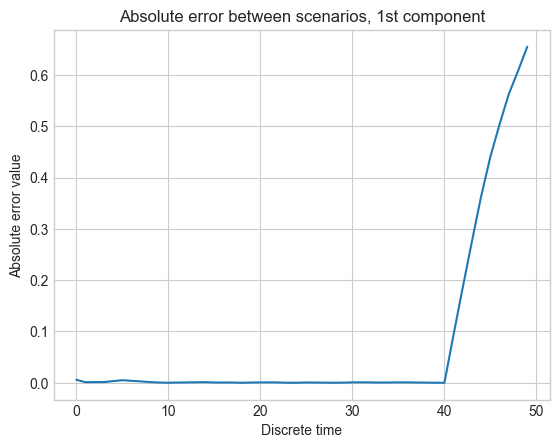

In [7]:
results, norms, index_frequency, mean_len = analyse_component(ts_expcosine_noisy, l = 10, n_component = 1)

print(f'Mean number of higly deviant observations: {mean_len}')
plt.plot(results['vector_50']) # здесь можно поменять на вектор vector_i, чтобы визуализировать для разных threshold 
plt.title('Absolute error between scenarios, 1st component')
plt.xlabel('Discrete time')
plt.ylabel('Absolute error value');

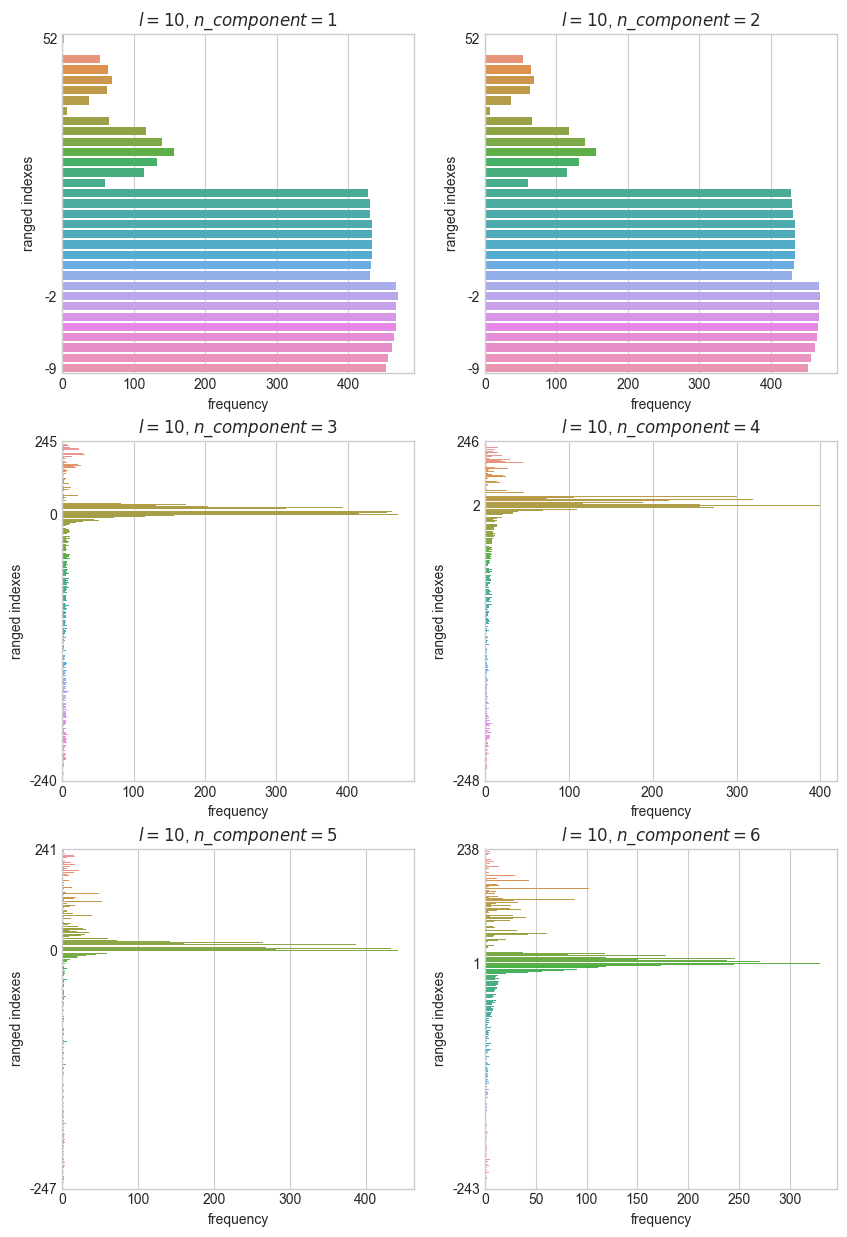

In [10]:
fig, ax = plt.subplots(3,2, figsize = (10,15))

for i, n_component in enumerate([1,2,3,4,5,6]):


    _, _, index_frequency, _ = analyse_component(ts_expcosine, l= 10, n_component=n_component)

    plot_frequencies(index_frequency, l = 10, n_component=n_component, ax = ax[i//2][i%2])

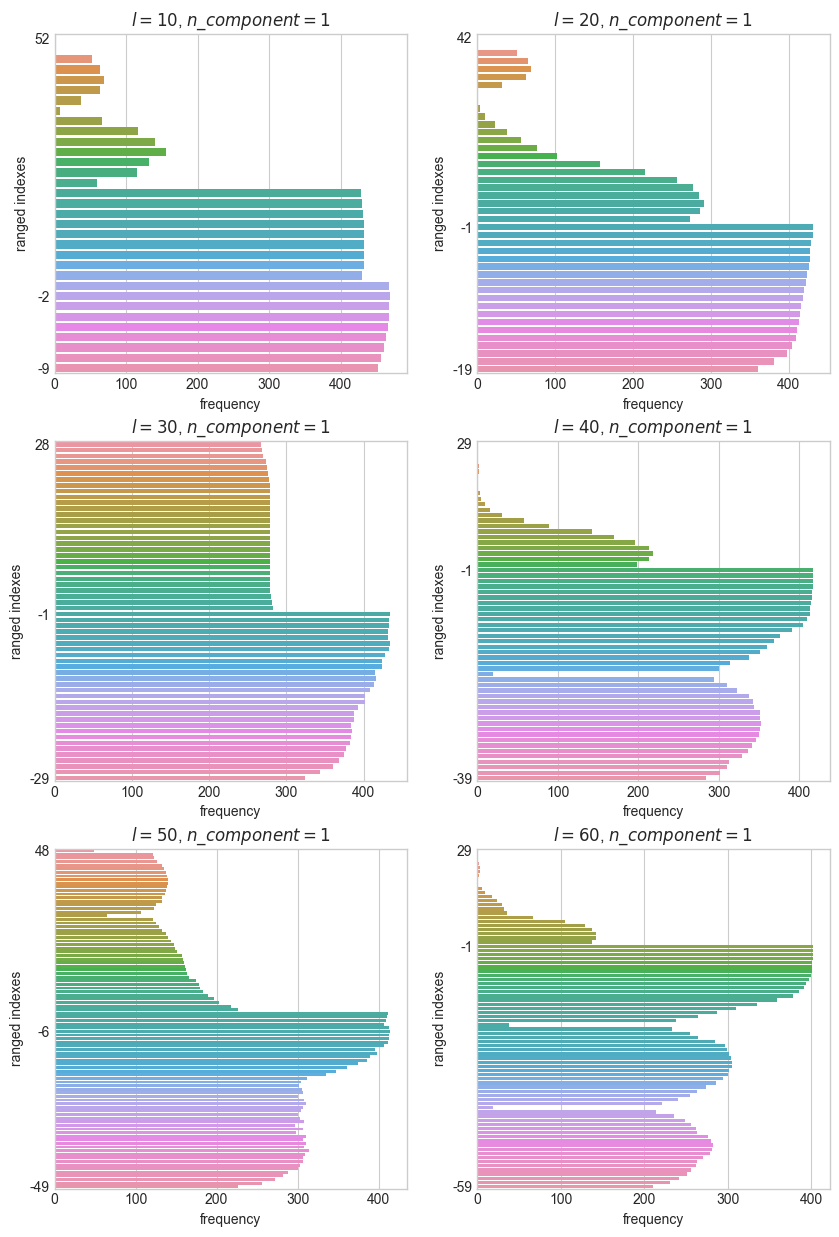

In [11]:
fig, ax = plt.subplots(3,2, figsize = (10,15))
n_component = 1
l_list = [10,20,30,40,50,60]
mean_len_list = []

for i, l in enumerate([10,20,30,40,50,60]):


    _, _, index_frequency, mean_len = analyse_component(ts_expcosine, l = l, n_component=n_component)
    mean_len_list.append(mean_len)
    plot_frequencies(index_frequency, l = l, n_component=n_component, ax = ax[i//2][i%2])

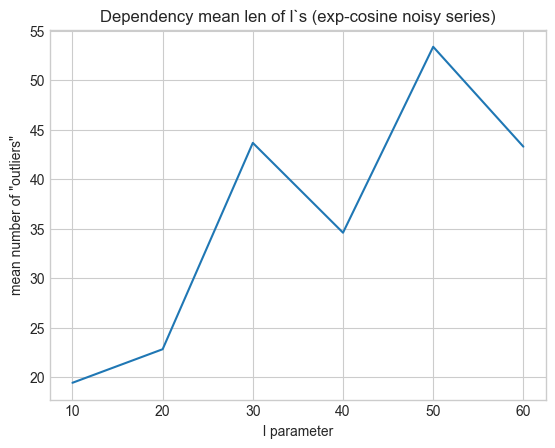

In [13]:
plt.plot(l_list, mean_len_list)
plt.xlabel('l parameter')
plt.ylabel('''mean number of "outliers"''')
plt.title('Dependency mean len of l`s (exp-cosine noisy series)');
plt.savefig('Fig.5 Dependency mean len of l`s (exp-cosine series).png', dpi = 300)

Полное исследование по той же сетке выявило похожую закономерность. Компоненты зашумленного ряда отчетливо делятся на 2 кластера: 1-2 компоненты, соответствующие исходному (незашумленному ряду), и 3-10. Этот **результат говорит о потенциальной возможности использовать зависимость количества ошибок от длины окна в качестве группирующего критерия**. 

In [ ]:
# полное исследование для зашумленного ряда 
l_list = np.arange(10,200,10)
n_components = np.arange(1,11)
mean_len_matrix_exp = np.zeros((l_list.shape[0], n_components.shape[0]))

for i, l in enumerate(tqdm(l_list)):
        mean_lengths = analyse_l(ts, l = l, n_components=n_components)
        mean_len_matrix_exp[i, :] += mean_lengths

np.save('exp_cosine_research', mean_len_matrix_exp)

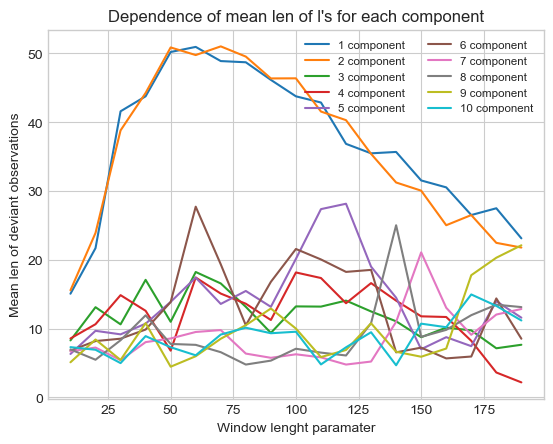

In [27]:
expcosine_matrix = np.load('exp_cosine_research.npy')
for i in range(10):
  plt.plot(np.arange(10,200,10), expcosine_matrix[:,i], label = f'{i+1} component')

plt.xlabel('Window lenght paramater')
plt.ylabel('Mean len of deviant observations')
plt.title("Dependence of mean len of l's for each component")
plt.legend(ncols = 2, fontsize = 'small');

# 5. Эксперименты с аппроксимацией


В этой части работы будет исследоваться ошибка аппроксимации исходного ряда малоранговым приближением, что принципиально отличается отличается от предыдущей задачи, где исследовалась ошибка между сценариями с "знанием будущего" и без. 

Графики абсолютных ошибок опровергают третью гипотезу: пики ошибок находятся не в конце и начале ряда, а в середине и предположительно связаны с резкими изменениями направления движения ряда (т.е. быстрыми скачками). Для незашумленного экспоненциально косинусного ряда ошибка имеет периодическую форму, что объясняется отсутствием второго вектора (тоже периодического) в базисе.  

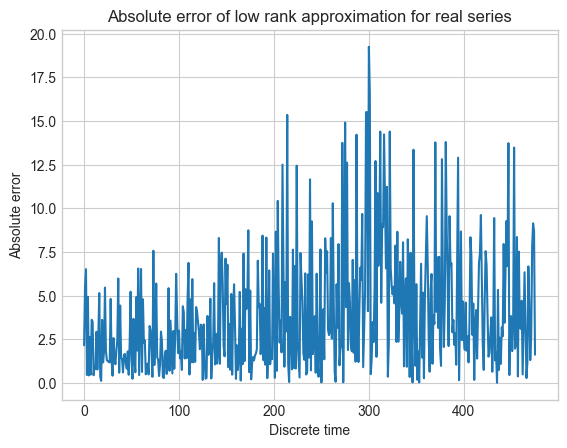

In [16]:
absolute_error = analyse_approximation(ts, l = 50, rank = 20)
plt.plot(absolute_error)
plt.xlabel('Discrete time')
plt.ylabel('Absolute error')
plt.title('Absolute error of low rank approximation for real series');

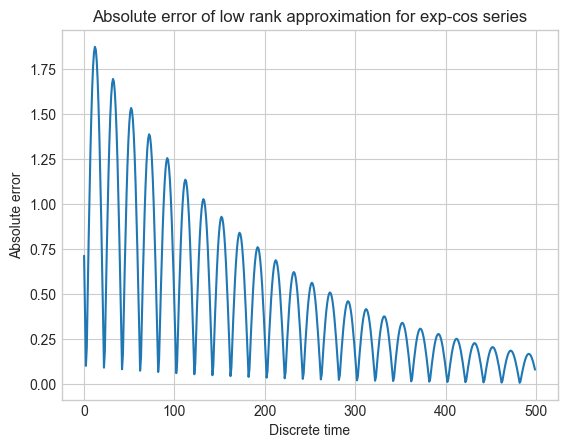

In [19]:
absolute_error = analyse_approximation(ts_expcosine, l = 50, rank = 1) # ранг > 1 даёт точное приближение
plt.plot(absolute_error)
plt.xlabel('Discrete time')
plt.ylabel('Absolute error')
plt.title('Absolute error of low rank approximation for exp-cos series');

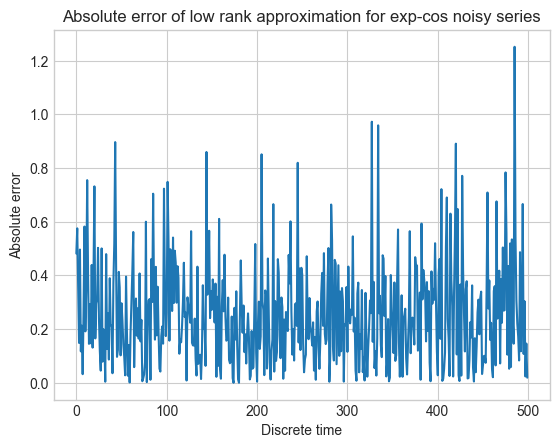

In [22]:
absolute_error = analyse_approximation(ts_expcosine_noisy, l = 50, rank = 20)
plt.plot(absolute_error)
plt.xlabel('Discrete time')
plt.ylabel('Absolute error')
plt.title('Absolute error of low rank approximation for exp-cos noisy series');

Варьирование длины окна не сказалось на форме кривой ошибок: в ней всё ещё есть пики, которые увеличиваются в абсолютном значении при увеличении $l$. То же характерно и для зашумленного ряда.

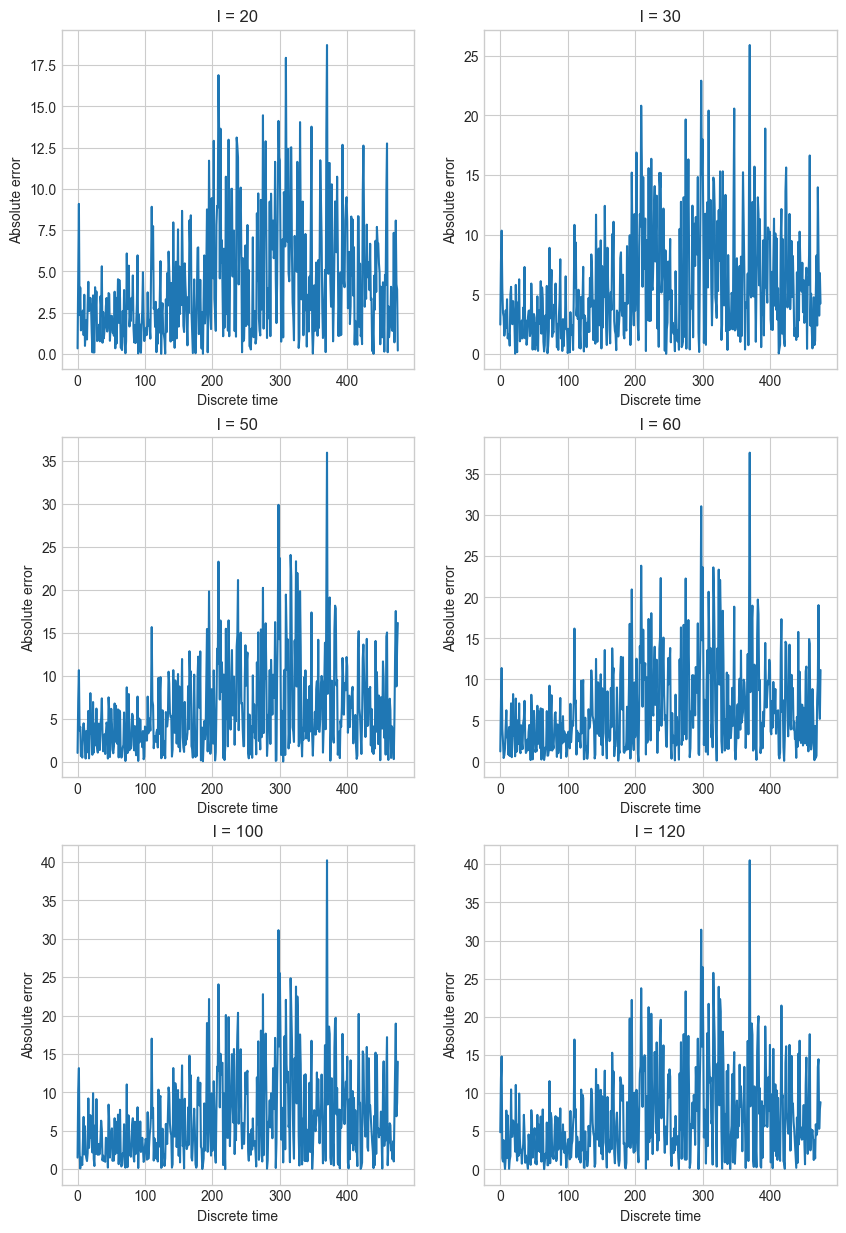

In [29]:
# разные l, rank = 10 для реальных данных

fig, ax = plt.subplots(3,2, figsize = (10,15))

l_list = np.array([20,30,50,60,100, 120])
for i, l in enumerate(l_list):
    errors = analyse_approximation(ts, l = l, rank = 10)
    ax[i//2][i%2].plot(errors)
    ax[i//2][i%2].set_xlabel('Discrete time')
    ax[i//2][i%2].set_ylabel('Absolute error')
    ax[i//2][i%2].set_title(f"l = {l}")

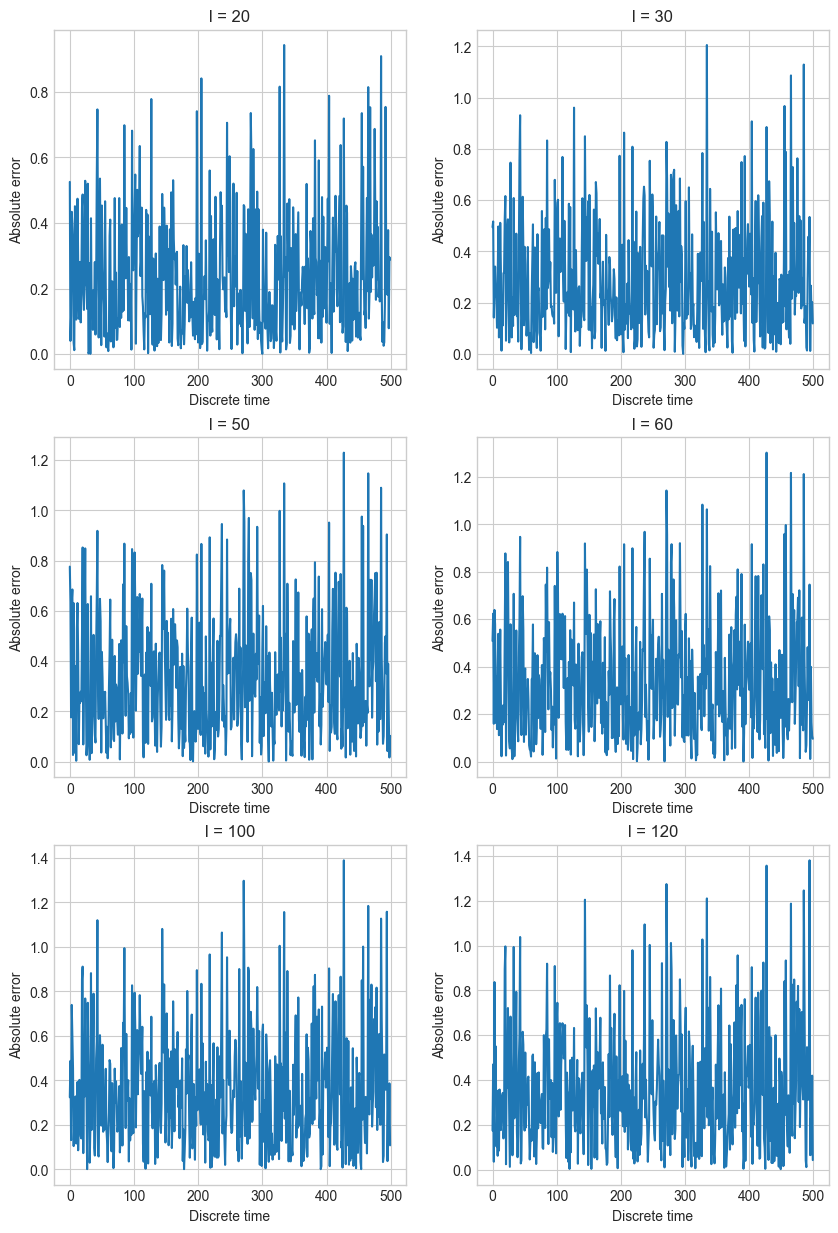

In [33]:
# разные l, rank = 10 для зашумленного экспоненциально-косинусного ряда

fig, ax = plt.subplots(3,2, figsize = (10,15))

l_list = np.array([20,30,50,60,100, 120])
for i, l in enumerate(l_list):
    errors = analyse_approximation(ts_expcosine_noisy, l = l, rank = 10)
    ax[i//2][i%2].plot(errors)
    ax[i//2][i%2].set_xlabel('Discrete time')
    ax[i//2][i%2].set_ylabel('Absolute error')
    ax[i//2][i%2].set_title(f"l = {l}")

# 6. Дробление ряда

Рассмотрим задачу применения SSA к большому ряду, SVD которого не поместится в оперативной памяти. Ряд необходимо дробить на кусочки размера $n$, но естественно предложить улучшенный подход в свете выше обсужденного. Пусть на каждой итерации мы будем делать пересечение с предыдущим кусочком на $L$ - длину окна. 

Чтобы сравнить подходы, выберем финансовый ряд в $10^4$ наблюдениями и применим SSA, выделяя первую компоненту:

а) ко всему ряду целиком. Именно с этим рядом будем сравнивать подходы 

б) по отдельности для каждого кусочка размерности $n$ без пересечений

в) для каждого кусочка с пересечениями

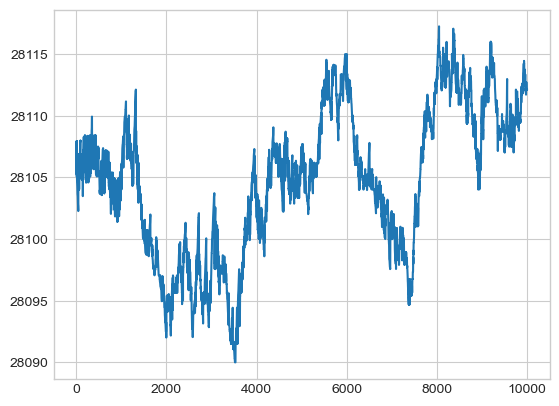

In [2]:
ts = pd.read_csv(r'D:\Python_projects\hft_project\trades.spot.csv', nrows = 10**4)['price'].dropna().to_numpy()
plt.plot(ts);

  0%|          | 0/10 [00:00<?, ?it/s]

MAPE of approximation: 3.868528450995647e-06


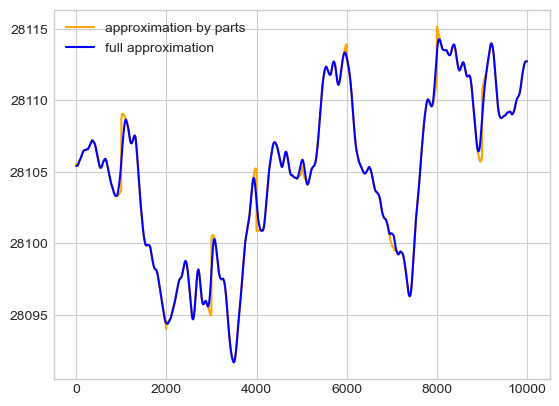

In [7]:
from sklearn.metrics import mean_absolute_percentage_error
from tqdm.notebook import tqdm

N = 1000
L = 100

ssa = SSA(l = L)
transformed_ts, _ = ssa.transform_to_series(ts)
transformed_ts = transformed_ts[0,:]
ts_reconstructed = np.zeros((len(transformed_ts))) # SSA по частям

# без пересечений для первой компоненты
for num_batch in tqdm(range(len(ts) // N)):
    ts_1 = ts[num_batch*N : (num_batch+1)*N]
    
    ssa = SSA(l = L)
    ssa_ts_1,_ = ssa.transform_to_series(ts_1)
    ssa_ts_1 = ssa_ts_1[0,:]

    ts_reconstructed[num_batch*N : (num_batch+1)*N] += ssa_ts_1     

print('MAPE of approximation:', mean_absolute_percentage_error(ts_reconstructed, transformed_ts))
plt.plot(ts_reconstructed, label = 'approximation by parts', color = 'orange')
plt.plot(transformed_ts, label = 'full approximation', color = 'blue')
plt.legend()
plt.savefig('Approximation without intersection.png', dpi = 300)
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

MAPE of approximation: 1.0501079912783388e-06


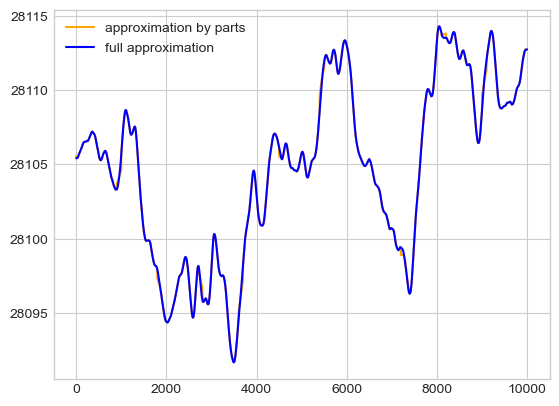

In [6]:
# с пересечениями

ts_reconstructed = np.zeros((len(transformed_ts))) # SSA по частям

for num_batch in tqdm(range(1+(len(ts) - N) // (N-L))):
    if num_batch == 0:
        ts_1 = ts[num_batch*N : (num_batch+1)*N]
    else:
        ts_1 = ts[num_batch*(N-L) : num_batch*(N-L) + N]
        
    
    ssa = SSA(l = L)
    ssa_ts_1,_ = ssa.transform_to_series(ts_1)
    ssa_ts_1 = ssa_ts_1[0,:]

    if num_batch == 0:
        ts_reconstructed[num_batch*N : (num_batch+1)*N] += ssa_ts_1
    else:
        ts_reconstructed[num_batch*(N-L) : num_batch*(N-L) + N] += ssa_ts_1
        ts_reconstructed[num_batch*(N-L) : num_batch*(N-L) + L] *= 1/2

print('MAPE of approximation:', mean_absolute_percentage_error(ts_reconstructed, transformed_ts))
plt.plot(ts_reconstructed, label = 'approximation by parts', color = 'orange')
plt.plot(transformed_ts, label = 'full approximation', color = 'blue')
plt.legend()
plt.savefig('Approximation with intersection.png', dpi = 300)
plt.show()

**Ошибка аппроксимации снизилась в 3 раза.** 

# 7. Результаты

**Краткие итоги**

Итак, гипотезы в их изначальной формулировке не подтвердились, но выяснилось следующее
1. Информация о будущих наблюдениях сильнее всего влияет на первые и последние наблюдения лишь для компонент с наибольшими сингулярными числами. 
2. Варьирование длины окна немонотонно изменяет среднее количество ошибок между сценариями. Более того, *отчетливо выделяются кластеры компонент с похожим поведением*. Это наблюдение поможет в группировке компонент на тренд, гармоники и шум.
3. Ошибка малоранговой аппроксимации зависит не от индекса наблюдений, а от резких изменений в ряду. Она необязательно высока на первых и последних наблюдениях, но имеет пики там, где произошло неожиданное изменение значения ряда (неожиданность следует понимать с точки зрения общего тренда и гармоник, которые выделились с помощью малорангового SVD).
4. Предложена эффективная стратегия дробления ряда для применения к нему SSA по частям.

**Будущие исследования**

Вопросы ниже интересны для исследования с практической точки зрения

- Как корректировать алгоритм на первых компонентах для большей точности (предсказательной силы)?
- Как использовать выделяющиеся кластеры для группировки ряда? Подтверждается ли эта зависимость на других рядах с известными нешумовыми компонентами?